# Analyzing Steam Reviews
---

#### @rr1259 and @quickdesh




## Introduction

In the United States, over 65% of the population plays some form of video games. This popularity has created a 365 billion dollar industry. A video game becoming popular and gaining a large player base can therefore be hugely profitable for its company. When a new video games come out, one of the most important deciding factors in the success of the game is its reception by the initial players of the game. When a game is made well, word spreads quickly and brings more people to it. 

When it performs poorly, the game starts to lose steam and eventually gets left behind. For a game company and for analysts, understanding how a game will do in the future is essential to making decisions about its release and future updates.
This project's purpose is to identify what factors contribute to positive reception of a video game and what factors change if reviewers are likely to give a positive or negative review. Apex Legends is a popular video game that is updated every few months focusing on a specific theme. Each of these new updates is called a “season” within the game. We wanted to analyze its reviews to find patterns in the data and see how the sentiment about the game changed from season to season.


(Statistics Source : https://www.theesa.com/video-games-remain-americas-favorite-pastime-with-more-than-212-million-americans-playing-regularly/)


## Data Collection


The first step to analysis is collecting relevant data. For this we found that there was an API that steam had released, allowing for users to get information about game reviews of any game in their catalog. Using Kaggle, we found a dataset that contained the reviews and additional data for the "Apex Legends" game. This dataset contained the reviews for the game, the number of times a review was voted up, details about the user writing the review, the language of the review and the date of creation.
In order to test the accuracy of the model over reviews of different games, we utilized the steam review datasets from Counter Strike : Global Offensive and Fifa 23. Through Kaggle we were able to procure these datasets that had been extracted with the same API that was used to extract our original Apex Legends review dataset. Both these datasets contained similar information as the first but with different patterns of like-to-dislike ratios.


Apex Legends Steam Reviews : https://www.kaggle.com/datasets/noahx1/apex-legends-steam-reviews

Counter Strike Global Offensive Steam Reviews : https://www.kaggle.com/datasets/noahx1/csgo-steam-reviews

Fifa 2023 Steam Reviews : https://www.kaggle.com/datasets/noahx1/fifa-23-steam-reviews



In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
pd.options.mode.chained_assignment = None
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sacremoses import MosesTokenizer, MosesDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import plot_tree
from wordcloud import WordCloud

nltk.download("stopwords")
nltk.download("wordnet")

reviews_df =  pd.read_csv("Apex_Legends_Steam_Reviews.csv")
reviews_df.tail()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deves\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deves\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,language,review,created,voted_up,votes_up,comment_count,steam_purchase,recieved_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
71310,129545870,english,stupid game :),2022-12-28 21:31:31,False,1,0,False,False,False,42,1,41030,731,9818,2024-01-31 20:48:34
71311,129545713,english,its free,2022-12-28 21:29:21,True,0,0,False,False,False,0,11,1164,0,735,2023-01-15 02:06:16
71312,129544748,english,good times,2022-12-28 21:15:23,True,0,0,False,False,False,0,5,33148,0,18922,2023-10-29 19:36:30
71313,129544646,english,They ruined this game a long time ago.,2022-12-28 21:13:37,False,1,0,False,False,False,73,30,817,0,815,2023-11-22 01:50:57
71314,129543409,english,it gud for pew pew,2022-12-28 20:56:10,True,1,0,False,True,False,0,4,36912,0,23258,2023-12-09 01:24:07


## Data Curation

#### Dropping Columns

As *Apex Legends* is a free game with no history of an early access, the ***steam_purchase***, ***recieved_for_free*** and ***written_during_early_access*** columns are false for all users and thus has no use in our analysis.

In [300]:
columns_to_drop = ["steam_purchase", "recieved_for_free", "written_during_early_access"] # Yes, received is misspelled in the original data
reviews_df = reviews_df.drop(columns=columns_to_drop)
reviews_df.tail()

,id,language,review,created,voted_up,votes_up,comment_count,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
71310,129545870,english,stupid game :),2022-12-28 21:31:31,False,1,0,42,1,41030,731,9818,2024-01-31 20:48:34
71311,129545713,english,its free,2022-12-28 21:29:21,True,0,0,0,11,1164,0,735,2023-01-15 02:06:16
71312,129544748,english,good times,2022-12-28 21:15:23,True,0,0,0,5,33148,0,18922,2023-10-29 19:36:30
71313,129544646,english,They ruined this game a long time ago.,2022-12-28 21:13:37,False,1,0,73,30,817,0,815,2023-11-22 01:50:57
71314,129543409,english,it gud for pew pew,2022-12-28 20:56:10,True,1,0,0,4,36912,0,23258,2023-12-09 01:24:07


#### Dropping Rows

To mitigate the influence of outliers, particularly from players who may have played for less than 5 minutes or were potentially inactive (AFK) while the game was open in the background, we are going to use a sigma threshold of 5.


In [301]:
old_playtime_mean = reviews_df["author_playtime_at_review"].mean()
old_playtime_sd = reviews_df["author_playtime_at_review"].std()

reviews_df = reviews_df[reviews_df["author_playtime_at_review"] <= (old_playtime_mean + 5 * old_playtime_sd)]

new_playtime_mean = reviews_df["author_playtime_at_review"].mean()
new_playtime_sd = reviews_df["author_playtime_at_review"].std()

print("Given below are the mean and sd of playtimes after removing outliers:")
print("Mean hours played at review :", float(new_playtime_mean) / float(60))
print("Standard deviation of hours played at review :", float(new_playtime_sd) / float(60))

Given below are the mean and sd of playtimes after removing outliers:
Mean hours played at review : 255.78746204536694
Standard deviation of hours played at review : 400.3336158874043


In [302]:
old_playtime_r_mean = reviews_df["author_playtime_forever"].mean()
old_playtime_r_sd = reviews_df["author_playtime_forever"].std()

reviews_df = reviews_df[reviews_df["author_playtime_forever"] <= (old_playtime_r_mean + 5 * old_playtime_r_sd)]

new_playtime_r_mean = reviews_df["author_playtime_forever"].mean()
new_playtime_r_sd = reviews_df["author_playtime_forever"].std()

print("Given below are the mean and sd of total playtimes after removing outliers:")
print("Mean hours played in total:", float(new_playtime_r_mean) / float(60))
print("Standard deviation of hours played in total :", float(new_playtime_r_sd) / float(60))

Given below are the mean and sd of total playtimes after removing outliers:
Mean hours played in total: 341.4120594212534
Standard deviation of hours played in total : 469.0161215167089


Similarly, we will also mitigate the outliers that sprout up in the ***author_num_games_owned*** column, once again using a sigma threshold of 5.

In [303]:
old_games_mean = reviews_df["author_num_games_owned"].mean()
old_games_sd = reviews_df["author_num_games_owned"].std()

reviews_df = reviews_df[reviews_df["author_num_games_owned"] <= (old_games_mean + 5 * old_games_sd)]

new_games_mean = reviews_df["author_num_games_owned"].mean()
new_games_sd = reviews_df["author_num_games_owned"].std()

print("Given below are the mean and sd of games owned after removing outliers:")
print("Mean number of games owned :", float(new_games_mean))
print("Standard deviation of games owned :", float(new_games_sd))

Given below are the mean and sd of games owned after removing outliers:
Mean number of games owned : 25.590238284804368
Standard deviation of games owned : 61.79211741489248


As our main focus is the ***reviews*** column, we will need to drop all rows within the data that may contain a Null / None value in its features.

In [304]:
reviews_df = reviews_df.dropna()
reviews_df.describe

<bound method NDFrame.describe of               id language                                             review  \
0      157354180  english                                          very good   
1      157354070  english                                    why are gay !!!   
2      157353743  english                                 good game, play it   
3      157352109  english  DO NOT PLAY THIS GAME ITS A DOG SHIT, EA CANT ...   
4      157351840  english                                           nigger\n   
...          ...      ...                                                ...   
71310  129545870  english                                     stupid game :)   
71311  129545713  english                                           its free   
71312  129544748  english                                         good times   
71313  129544646  english             They ruined this game a long time ago.   
71314  129543409  english                                 it gud for pew pew   

     

#### Reformatting Columns

There are quite a few dates represented in the data, however they are not yet registered as a *datetime* data type. The following code block will make those corrections so that we may use the data moving forward

In [305]:
reviews_df["created"] = pd.to_datetime(reviews_df["created"])
reviews_df["author_last_played"] = pd.to_datetime(reviews_df["author_last_played"])

#### New Columns

To make better use of the ***voted_up*** column in our analysis, we will introduce a new column which simply converts the boolean into numerical data.


In [306]:
reviews_df["voted_up_int"] = reviews_df["voted_up"].replace({"False" : 0 , "True" : 1})

As an additional feature of the reviewers" playtimes, we will create a column that represents the playtime of a reviewer since they posted the review.

In [307]:
reviews_df["hours_played_since_review"] = ((reviews_df["author_playtime_forever"] - reviews_df["author_playtime_at_review"]) / 60).clip(lower=0).astype(int)

To get a better indicator of valid reviews (non-empty and non-ASCII art) within the data, we will create a new column that counts the number of words within a review by splitting it on white spaces

In [308]:
reviews_df["review_length"] = reviews_df["review"].apply(lambda x: len(re.findall(r"\b\w+\b", x.lower())) if pd.notnull(x) else 0) 

Since we are interested in looking into the seasons of the game, we will create a new column that uses the ***author_playtime_at_review*** column and the given below dates to categorize each review under a specific *season*

(Data pulled from *https://apexlegends.fandom.com/wiki*)

> **2022-11-01** *(End of Season 14)*
> 
> **2023-02-14** *(End of Season 15)*
> 
> **2023-05-09** *(End of Season 16)*
> 
> **2023-08-08** *(End of Season 17)*
> 
> **2023-10-31** *(End of Season 18)*
> 
> **2024-02-13** *(End of Season 19)*

In [309]:
# Function to categorize the dates in the data into seasons based on the bracket it fits in
labels = [15 , 16, 17, 18, 19]
def get_season_from_datetime(date_series):
    seasons_end_dates = pd.to_datetime(["2022-11-01", "2023-02-14", "2023-05-09", "2023-08-08", "2023-10-31", "2024-02-13"], format = "%Y-%m-%d")
    return pd.Series(pd.cut(date_series, seasons_end_dates, labels = labels)).astype(int)

reviews_df["apex_season"] = get_season_from_datetime(reviews_df["created"])

For categorical tests, we will also be using the amount of time played. The code block below will categorize the ***author_playtime_at_review*** column as shown below (all times are in hours):

> **0000 - 0002** *(Couple of rounds)*
> 
> **0002 - 0010** *(A few games)*
> 
> **0010 - 0060** *(Decent trial of the game)*
> 
> **0060 - 0150** *(Irregular casual)*
> 
> **0150 - 0400** *(Regular casual)*
> 
> **0400 - 1000** *(Regular competitive)*
> 
> **1000 - 2000** *(Highly competitive)*
> 
> **2000 - 5000** *(Professional)*

In [310]:
labels = ["0-2", "2-10", "10-60", "60-150", "150-400", "400-1000", "1000-2000", "2000-5000"]
# Function to categorize the dates in the data into seasons based on the bracket it fits in
def get_hour_category(x):
  hour_list = [0, 120, 600, 3600, 9000, 24000, 60000, 120000, 300000]
  return pd.Series(pd.cut(x, hour_list, labels = labels)).astype(str)

reviews_df["author_playtime_at_review_category"] = get_hour_category(reviews_df["author_playtime_at_review"])

## Exploratory Data Analysis

For all the following tests, we will assume an ***alpha*** value of *0.05*.

### First Statistical Test (ANOVA):

**Test:** Correlation between amount of game time at review and review"s approval of the game

**Null Hypothesis H0:** Amount of time played in the game has no impact on whether the game was approved of.

**Alternative Hypothesis HA:** Amount of time played in the game has a correlation with whether the game was approved of.

By using the categorized version of the ***author_playtime_at_review***, we can use Anova test to determine whether the playtime has an effect on the reviewer"s approval of the game

In [311]:
# Function to get the reviewr"s approval (in int) based on the hour range
def get_date(hour_range):
  return reviews_df["voted_up_int"][reviews_df["author_playtime_at_review_category"] == hour_range]

p_value = stats.f_oneway(get_date("0-2"), get_date("2-10"), get_date("10-60"), get_date("60-150"), get_date("150-400"), get_date("400-1000"), get_date("1000-2000"), get_date("2000-5000")).pvalue
print("p-value = ", p_value)

p-value =  4.594097236127293e-309


Our *p-value* is ***1.01E-306***.

This is far below our **alpha** value of *0.05*, thus can reject the null hypothesis.

The ANOVA Test shows that there is a very high correlation between time played and the approval of the reviewer. 

This aligns with real-life expectations.

It"s intuitive to assume that players who enjoy a game will invest more time in it.

**Representation:** By putting all the reviewers into their categories and then splitting them up based on their approval of the game, we can showcase the ratio of approval in each category

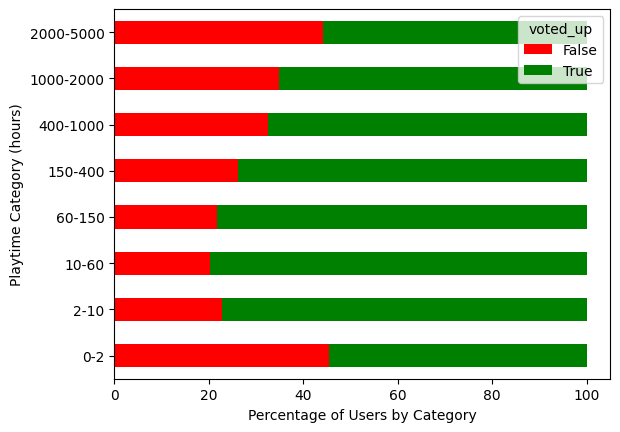

In [312]:
reviews_df.groupby("author_playtime_at_review_category")["voted_up"].value_counts(normalize=True).unstack().reindex(labels).plot(kind="barh", stacked=True, color=["red", "green"])
plt.xlabel("Percentage of Users by Category")
plt.ylabel("Playtime Category (hours)")
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 20, 40, 60, 80, 100])
plt.show()

The above data is represented using a stacked, normalised horizontal bar graph.

Overall the test and its corresponding representation showcases that more playtime equates to a higher approval rate among reviewers.

### Second Statistical Test (T-Test + correlation):

**Test:** Correlation between number of games owned and the amount of time played after review

**Null Hypothesis H0:** Number of games owned by the reviewer has no effect on amount of time played after reviewing

**Alternative Hypothesis HA:** Number of gamed owned by the reviewer has an effect on amount of time played after reviewing

By using the two columns (***hours_played_since_review*** and ***author_num_games_owned***), we can use Pearson Coorelation Statistic to find the relation between the two points of data.

Applying a T-Test on the above relationship will give us the corresponding p-value.

In [313]:
correlation_coef, p_value = stats.pearsonr(reviews_df["author_num_games_owned"], reviews_df["hours_played_since_review"])
print("p-value = ", p_value)

p-value =  2.7340578759850367e-37


Our *p-value* is ***8.26E-32***.

This is well below our **alpha** value of *0.05*, thus can reject the null hypothesis.

The T-Test shows that there is a high correlation between time played since review and the number of games owned by the reviewer. 

This aligns with real-life expectations.

It"s intuitive to assume that players that own more games would spend time playing them, rather than sticking to just one.

**Representation:** By mapping each reviewer to their respective features, we can show case the graph trend of the data.

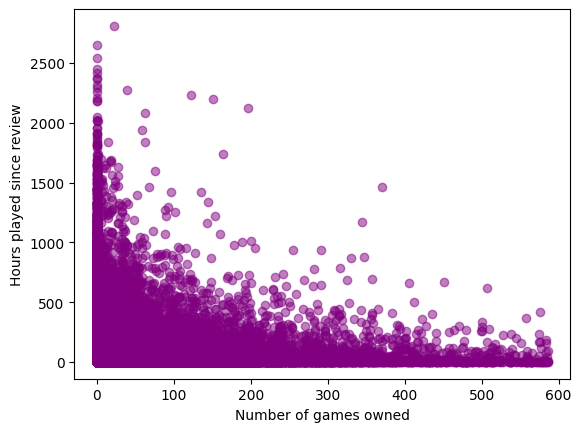

In [314]:
plt.scatter(reviews_df["author_num_games_owned"], reviews_df["hours_played_since_review"], alpha = 0.5, color="purple")
plt.xlabel("Number of games owned")
plt.ylabel("Hours played since review")
plt.show()

The above data is represented using a scatter plot.

Overall the test and its corresponding representation showcases that the more games a reviewer owns, they tend to spend less time on the game past review

### Third Statistical Test (Chi2 Contigency Test)


**Test:** Correlation between season number and length of reviews in said season.

**Null Hypothesis H0:** There is no relation between the season number and the number of words in reviews during the season.

**Alternative Hypothesis HA:** There is a correlation between season number and the number of words in reviews during the season.

By crosstab, we can tabulate the data in the ***apex_season*** and ***review_length*** columns into a contingency table.

To make the categories, we are using Bins (Max words / 4) to seperate the number of words into ranges to prevent sensitivity to outliers.

Applying the Chi2 test on the above table will give us the corresponding p-value.

In [315]:
bins = int(reviews_df["review_length"].max() / 4)
cross_tab = pd.crosstab(reviews_df["apex_season"], pd.cut(reviews_df["review_length"], bins = bins))
chi_test = stats.contingency.chi2_contingency(cross_tab, correction=False)
print("p-value = ", chi_test.pvalue)

p-value =  0.03291277283627077


Our *p-value* is ***0.03***.

This is just below our **alpha** value of *0.05*, thus can reject the null hypothesis.

The T-Test shows that there is a correlation between the season the review was posted and the words in said review. 

This aligns with real-life expectations.

It"s intuitive to assume that seasons were recieved differently and thus reviewers would want to voice out their concerns based on how well the game season went.

**Representation:** By mapping the contingency table to tje graph, we can show the split between the seasons

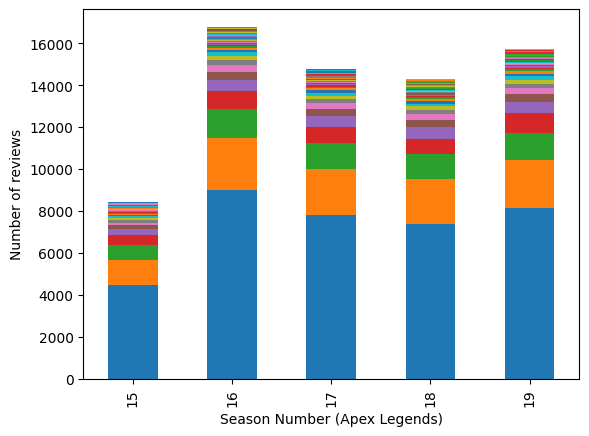

In [316]:
ax = cross_tab.plot(kind="bar", stacked=True)
plt.legend().set_visible(False)
plt.xlabel("Season Number (Apex Legends)")
plt.ylabel("Number of reviews")
plt.show()

The above data is represented used a stacked, bar plot.

Each stack (color) in a bar represents a different bin. 

> The first, and largest bin (blue) represents reviews with 0 to 4 words.
>
> The second bin (orange) represents the number of reviews with 4 to 8 words.
>
> The third bin (green) represents the number of reviews with 8 to 12 words.
>
> ...and so on.

## NLP

### Preprocessing Text Data


Preprocessing is a mandatory step in NLP done before vectorization. The reasons for this are because there could be characters which are uppercase, which need to be turned to lowercase to allow uniformity of words across the honeypots.

There might also be a lot of unnecessary words like "a", "the", "an" etc that are too common to have any significant meaning in the reviews.
These are called stopwords and should be removed because they might show up in every review and have no contribution to the end result. 
Additionally, all kinds of punctuation must also be removed as it is not necessarily required to extract meaning from the text.

In [317]:
def preprocess_text(inp):
    inp = inp.translate(str.maketrans("", "", string.punctuation))

    inp = inp.lower()

    toks = MosesTokenizer(lang="en").tokenize(inp)

    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in toks if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemmed_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    preproc_text = " ".join(lemmed_tokens)

    return preproc_text

To achieve the required modifications for efficient TF-IDF vectorization, we made the preprocess_text() function as shown above. We use the NLTK Natural language processing library for this part. It starts by using the string module to remove punctuations throughout the review text. Following this, the whole string is turned to lowercase and the Moses Tokenizer to split the text into tokens. The stop words arethen removed using the NLTK stopwords library downloaded above. 

This is checked against each of the tokens to remove the unnecessary words.
Following this, the text is run through the Lemmatizer to reduce the number of unique words by reducing words to their roots. 
The tokens are then joined back together with spaces and returned as preprocessed text.

#### Why the Moses Tokenizer?



The reason we used MosesTokenizer and not just a split command is because tokenizers will take multiword tokens together rather than separating them into 2 different tokens
(Ex. "Los Angeles" would be "Los Angeles" rather than "Los", "Angeles").

This maintains relation between words.

(Package details : https://pypi.org/project/mosestokenizer/\)

#### Why Lemmatization?


For a NLP model to properly process data, it has to be simplified into a form more understandable for the model. The TF-IDF vectorizer produces a separate table for each unique word in the corpus (collection of all the reviews). This is obviously a very long process for a dataset containing more than 70000 reviews. Lemmatization is used to reduce words to their root form also known as "Lemma"s.

For example if a review said the game "is running well." and another said the game "runs well.", using TF-IDF we would need 2 different tables for "runs" and "running" even though in this context they mean the same thing i.e. "run". This gives rise to a much larger amount of tables than required for words that already have been accounted for we found this to be the case since without lemmatization the TF-IDF output was extremely large. Using lemmatization, we can shrink the number of unique words in TF-IDF by condensing different versions of the same word down to a root lemma.

Another option for carrying out this procedure was "Stemming" which reduces the size of larger words to something close to their root meaning while still keeping it unique. However, this results in a similarly sized TF-IDF matrix as compared to a TF-IDF done without stemming and would be more useful for a smaller dataset. Additionally, lemmatization is generally considered more helpful than stemming in NLP Analyses leading to its preference.

(Source: https://www.baeldung.com/cs/stemming-vs-lemmatization)


### Machine Learning


For this part of the project, we wanted to use a machine learning model to classify the reviews into positive and negative.

We had seen in previous course work for CMSC320 that the Random Forest Classifier was the most accurate one out of all the classifiers. We decided to use this to have the higest accuracy in predicting the sentiment of game reviews.

In [318]:
X = reviews_df["review"].apply(preprocess_text)
y = reviews_df["voted_up_int"]

#### Creating input and output vectors

The preprocess text function is applied to each of the reviews to create "X" vector, the input for the model. This is what the model will be trained off of and tested on as well. "y" shows if the user has given the game a "thumbs up" or "thumbs down" and can be used to test the accuracy of our model. It produces the output vector y.


#### Splitting data for training and testing

We split the data into training and test data with sklearn"s train_test_split function. We reserve 20% of the data for testing and the rest is used to train the model.

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

The fillna() function of pandas needs to be used because TF-IDF vectorization is very sensitive to null values. It produces errors if this step is omitted because it will not be able to produce a matrix for a value that does not exist.

 Even though we cleaned the data, this is used as a contingency in case we missed something.

In [320]:
X_train.fillna("", inplace=True)
X_test.fillna("", inplace=True)
X_train.tail()

47859                                                  yes
63339         game matchmaking depressing love apex legend
21452                                                 nice
63642                                            came fast
11396    still great game year buy battle pas play enou...
Name: review, dtype: object

### TF-IDF Vectorization


For any kind of processing to occur in NLP, the words need to be converted to some numerical values or vectors. We use a TF-IDF Vectorizer to achieve this.

TF-IDF (Term Frequency — Inverse Document Frequency) is a vectorization technique that utilizes TF and IDF, the number of times a word occurs in a document and in the corpus (a collection of documents). The rarer words are given greater weight since they carry more unique meaning. It produces a vector representation of each word and its respective weights based on its frequency of occurence.

Below, we initialize the vectorizer and fit the training data to it.


In [321]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

TfidfVectorizer()

We now must transform the input by passing it through the vectorizer so we can run it through the model.


In [322]:
X_train_vec = tfidf_vectorizer.transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

#### Intializing the Model


We initialize our random forest classifier and fit the vectorized training data to it below. This is the training step and takes the longest time and most computation to complete out of all the steps.

In [323]:
model = RandomForestClassifier()
model.fit(X_train_vec,y_train)

RandomForestClassifier()

### Predicting outputs with test data

Below we use the predict() function sklearn, supplying the vectorized testing input.

In [324]:
y_pred = model.predict(X_test_vec)
y_pred

array([ True,  True, False, ...,  True,  True,  True])

We now test the accuracy of the model against the actual values of the test dataset.


In [325]:
accuracy = accuracy_score(y_test, y_pred)
print("Apex legends Accuracy = ", accuracy)

Apex legends Accuracy =  0.8431722464130202


Our model produces high accuracy > 0.8 with reviews from the Apex Legends database, meaning we can successfully determine if any review of the game, whether on steam or otherwise is positive or negative.

### Sentiment Analysis for other games


We have a trained model that produces accurate results for Apex Legends reviews but can we extend this to predict if a review of any arbitrary game is good or bad ?
To test this, we have 2 games Counter Strike Global Offensive and Fifa 2023.

#### Choice of games

CSGO is a game that is not too dissimilar from Apex Legends, being a online multiplayer first person shooter. FIFA 23 on the other hand, is completely different from Apex Legends, being a football game that could be single player in a campaign or multiplayer PvP. This gives us a similar and dissimilar game to test our model on.

#### Testing the model for other games





We use similar steps as above for testing both CSGO and FIFA.  We preprocess the data same as before and run the preprocessed review texts through the TFIDF vectorizer. We do not need to split the data or fit it to the model as before, since we are only predicting the sentiment based on the model already trained with Apex Legends" reviews.


##### CSGO

In [326]:
review_df_c = pd.read_csv("csgo_steam_reviews.csv").dropna()

X_c = review_df_c["review"].apply(preprocess_text)
y_c = review_df_c["voted_up"].replace({"False" : 0 , "True" : 1})
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=10)
X_train_c.fillna("", inplace=True)
X_test_c.fillna("", inplace=True)
X_test_c.head(10)

1084     game good problem take much space get boring bot
617                                             good game
8772                      trash game trashier player love
9642                                            good game
13719                                           dont care
12964        good game russian play everyday amazing game
1706                                                     
10261              like men also like shooting people awp
7489                                       best rage game
7497                                       good game csgo
Name: review, dtype: object

In [327]:
X_train_vec_c = tfidf_vectorizer.transform(X_train_c)
X_test_vec_c = tfidf_vectorizer.transform(X_test_c)

y_pred_c = model.predict(X_test_vec_c)

accuracy_c = accuracy_score(y_test_c, y_pred_c)
accuracy_c

0.8935214881334188

##### Fifa 2023

In [328]:
review_df_f = pd.read_csv("fifa23_steam_reviews.csv").dropna()

X_f = review_df_f["review"].apply(preprocess_text)
y_f = review_df_f["voted_up"].replace({"False" : 0 , "True" : 1})
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, random_state=5)
X_train_f.fillna("", inplace=True)
X_test_f.fillna("", inplace=True)
X_test_f.head(10)

21323                                   good like football
11348                                            love game
14201                                         good quality
11822                               great game play friend
3197                                                 fgcfc
9221                       360 game could run high graphic
895                                                   ball
16220                                            nice game
2999                                        hate anticheat
12609    felaket bir optimizasyon sorunu var sistemim g...
Name: review, dtype: object

In [329]:
X_train_vec_f = tfidf_vectorizer.transform(X_train_f)
X_test_vec_f = tfidf_vectorizer.transform(X_test_f)

y_pred_f = model.predict(X_test_vec_f)

accuracy_f = accuracy_score(y_test_f, y_pred_f)
accuracy_f

0.8113428181641006

## Visualization

### Decision Tree

Below we have extracted a decision tree from the RandomForest classifier, we only display a few layes of this tree since the whole thing would be too large. The actual Classifier uses 100 of these trees (the default) to train. This allows it to reduce overfitting and the results of exceptional decision trees by taking a consensus of multiple trees.

Each of the nodes show a feature (a word in the corpus) that is used to classify the datapoint. A less saturated hue of the node shows greater decisiveness, the end nodes are mostly colored with almost no saturation while nodes in the middle of the tree with lots of decisions to be made consequtively are colored lighter.

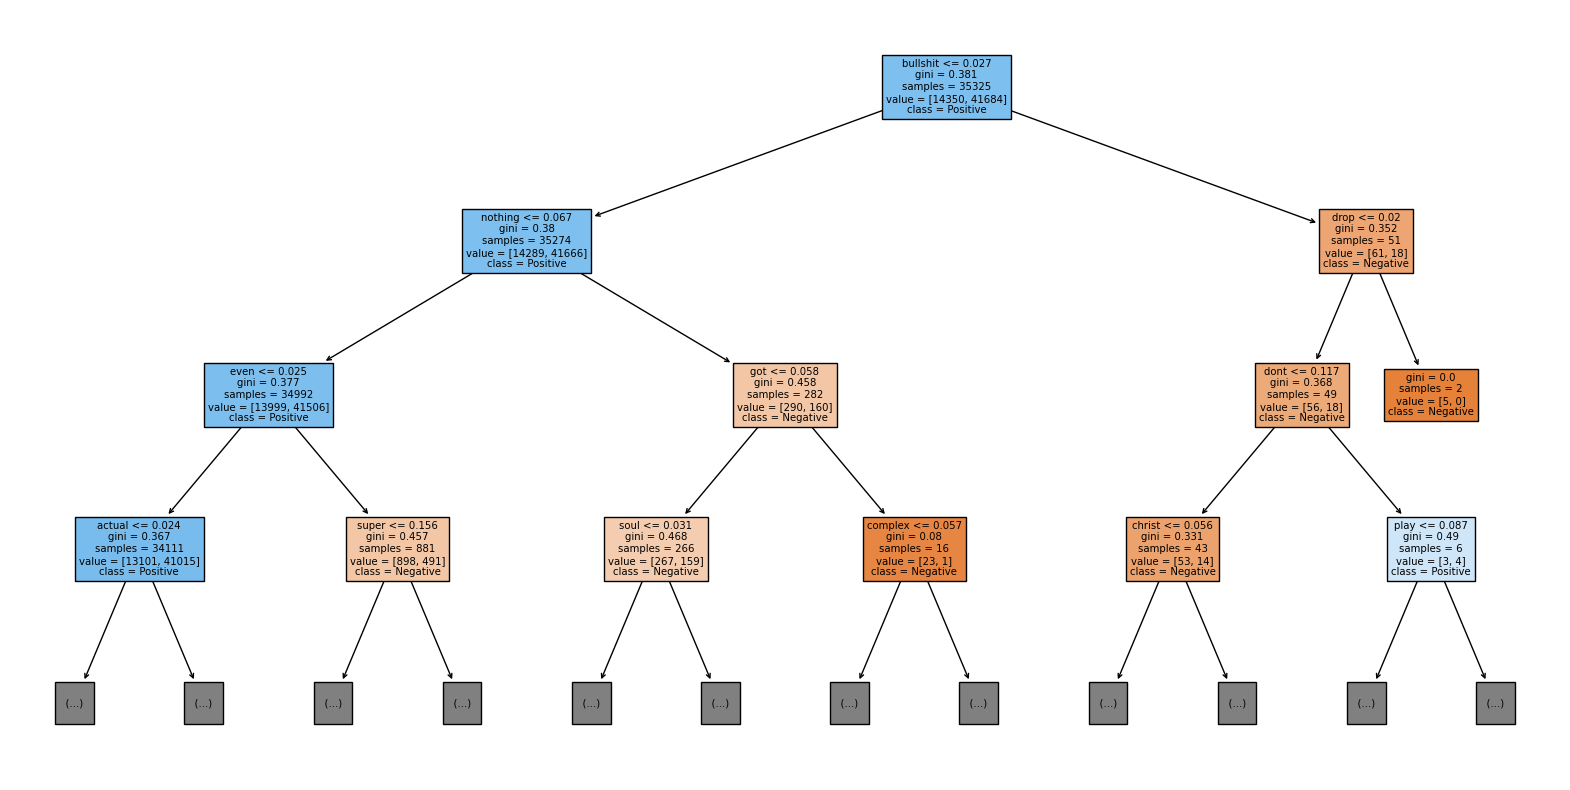

In [330]:
trees = model.estimators_
plt.figure(figsize=(20,10))
plot_tree(trees[6], max_depth=3, feature_names=tfidf_vectorizer.get_feature_names_out(), class_names = ["Negative", "Positive"], filled = True)
plt.show()

### Confusion Matrix


The confusion matrix tells us how good our model is performing. It shows the count of true positives, true negatives, false positives and false negatives as predicted by our model. As is shown, a majority of predictions fall into the true positive and false negative category, showing that we have high sensitivity and specificity.


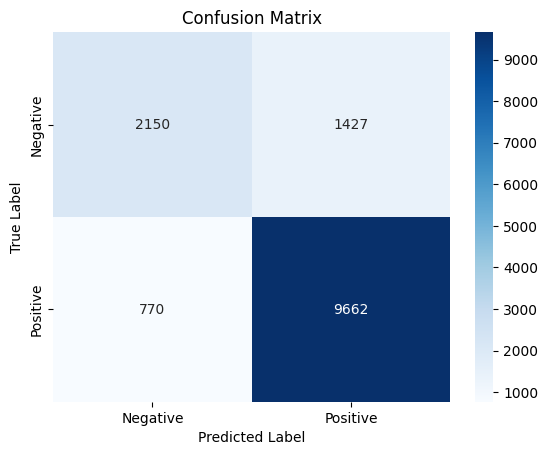

In [331]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Word Cloud

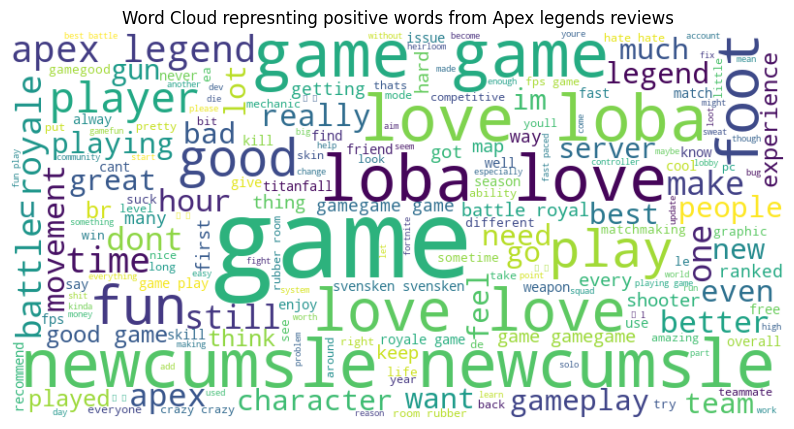

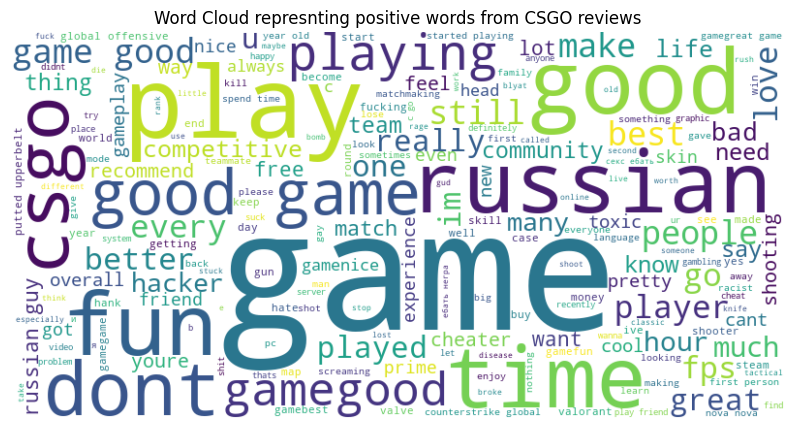

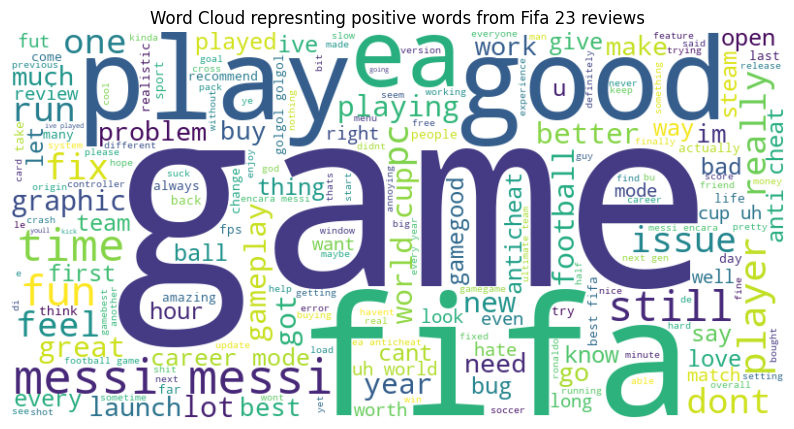

In [332]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate("".join(X_test[y_test == 1]))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud represnting positive words from Apex legends reviews")
plt.axis("off")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color="white").generate("".join(X_test_c[y_test_c == 1]))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud represnting positive words from CSGO reviews")
plt.axis("off")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color="white").generate("".join(X_test_f[y_test_f == 1]))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud represnting positive words from Fifa 23 reviews")
plt.axis("off")
plt.show()

## Insights and Conclusions


From Exploratory Data Analysis :

First Test :
We found that playtime has an impact on whether the reviewer approves or disapproves of the game.

Second Test :

The data showed that the more number of games a certain reviewer has, they spend less time playing the game after the review.
We have also seen that the playtime for the game at review time is positively correlated with the probability of it being upvoted.

Third Test :

We have found that the different game seasons represent different views on the game at the time by the reviewers. Some of the seasons had more reviews of longer length, indcating greater engagement with the community.

From Classification Model :

A key insight we got from this analysis is that though games fall into a wide variety of genres, there are a certain few keywords that are present across the 3 games' reviews like "bugs", "game", "good" and so on as seen in the word cloud visualization. We found that NLP with the TF-IDF vectorizer's input paired with the famously accurate Random Forest Classifier produces a very accurate model that can classify game reviews for atleast these 3 games, written on any platform, to understand if they are positive or negative reviews.
